In [1]:
from six.moves import cPickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from model import Model
from random import randint
import seaborn as sns; sns.set()

Using gpu device 0: GeForce 820M (CNMeM is disabled, CuDNN not available)


In [82]:
# Надо скинуть все необходимые файлы (с параметрами и моделью) в папку с программой :)
# Читаем параметры по пути path
# path = 'params00tune15iter.pckl'
# path = 'disp_min_params11tune_90pc_5iter.pckl'
path = 'params11tune5iter.pckl'

with open(path, 'rb') as f:
    model_params = cPickle.load(f)

In [83]:
d = dict() # ключ: параметр, значение: список реализаций
for steps in model_params:
    step = steps[1] # params after fine-tuning
    for parameter, value in step.iteritems():
        if parameter not in d:
            d[parameter] = []       
        d[parameter].append(value)

# Удаляем последний слой, не меняющийся в течение обучения
for _ in range(2):
    parameters = d.keys()
    d.pop(max(parameters))
# А также удаляем байесы
# !!! Обязательно для ковариаций
for parameter in parameters:
    if parameter[1] == 1:
        d.pop(parameter)

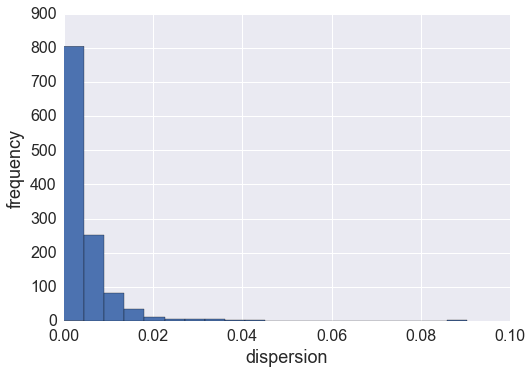

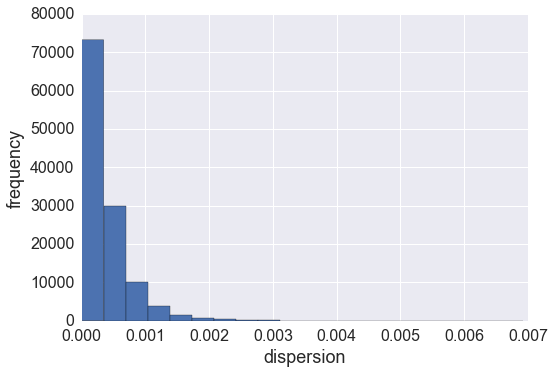

In [93]:
# Подсчёт дисперсий и построение гистограмм
dispersions = dict()
for parameter, values in d.iteritems():
    mean = np.mean(values, axis=0)

    dispersions[parameter] = np.sum([(value-mean)**2 for value in values], axis=0) / (len(values)-1)
    
    plt.hist(dispersions[parameter].flatten(), 20)
#     plt.title('Dispersions of parameters: layer %s'%str(parameter[0]))
    plt.xlabel('dispersion', fontsize=18)
    plt.ylabel('frequency', fontsize=18)
    plt.tick_params(axis='both',  labelsize=16)
    plt.show()

In [85]:
# Подсчёт ковариаций для нейронов
covariances = dict()
for parameter, values in d.iteritems():
    covariances[parameter] = [] # список ковариационных матриц, каждая матрица соответствует одному нейрону
    num_neurons = values[0].shape[1]
    for j in xrange(num_neurons):
        W = np.array([w.T[j] for w in values]).T # реализации вектора параметров (для нейрона) столбцами
        mean = np.mean(W, axis=1)
        deviation = W-mean.reshape(1,-1).T
        
        cov = np.absolute(deviation.dot(deviation.T))
        # Нормируем ковариации, деля на корень из произведения дисперсий (получаем корреляционную матрицу)
        # !!! Закомментировать для Белсли
#         disp = cov.diagonal().reshape(1,-1)
#         cov = cov/(disp.T.dot(disp))**(1./2)
        
        covariances[parameter].append(cov)

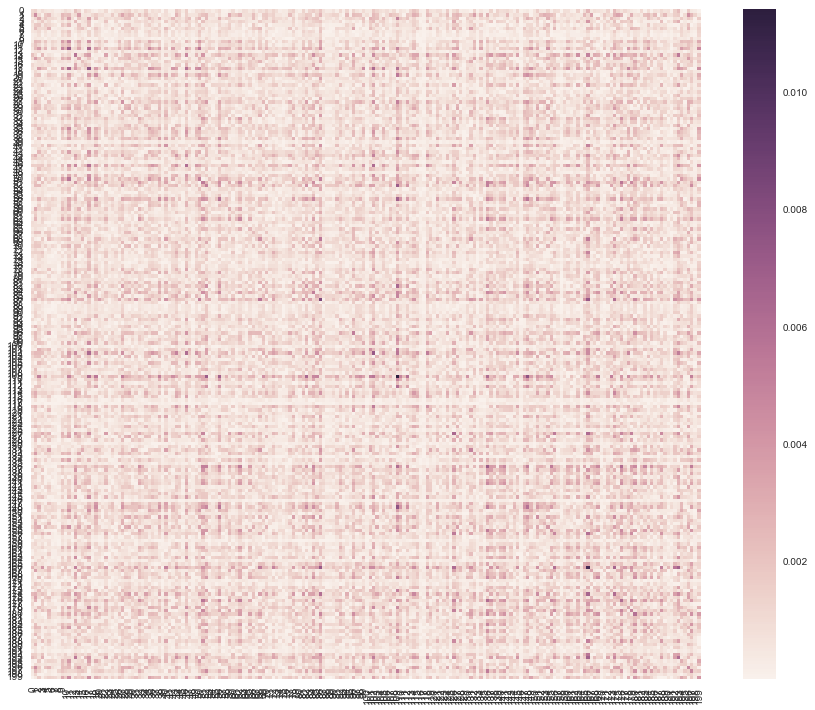

In [97]:
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(covariances[(1,0)][21][:200, :200])

In [15]:
# По ковариациям
def make_sparse_and_create_mask2(model_path, percent, method):
    # model_path: path of pretrained model
    # percent: percent of parameters to remove
    # method: remove parameters by 'max', 'min', 'rand' covariance
    
    # Читаем объект предобученной модели по пути path
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
        
    mask_file = open('corr_'+method+'_'+model_path+'_'+str(percent)+'pc.txt', 'w')
    for parameter, covariances_neurons in sorted(covariances.iteritems()):
        new_weights = model.model_description.blocks[parameter[0]].params[parameter[1]].eval()
        
        num_neurons = len(covariances_neurons)
        for j in xrange(num_neurons):
            cov = covariances_neurons[j] # ковариации для нейрона
            estimates = np.sum(cov,axis=0) # для каждого параметра его оценка - это сумма его ковариаций
            
            min_bound = sorted(estimates)[len(estimates)*percent/100]
            max_bound = sorted(estimates)[len(estimates)*(100-percent)/100]

            # Условие удаления параметра (веса)
            def condition(est):
                if method=='max':
                    return est >= max_bound
                elif method=='min':
                    return est <= min_bound
                elif method=='rand':
                    return randint(1,100) <= percent
                else:
                    raise Exception('unknown method')

            for i in range(len(estimates)):
                if condition(estimates[i]):
                    new_weights[i][j] = 0.
                    mask_file.write(str(i)+' '+str(j)+';')

        mask_file.write('\n\n')
        
        model.model_description.blocks[parameter[0]].params[parameter[1]].set_value(new_weights)

    mask_file.close()
    with open('corr_'+method+'_'+model_path+'_'+str(percent)+'pc', 'wb') as out:
        pickle.dump(model, out)

In [66]:
for p in (10,30,50,70,90):
    for m in ('max','min'):
        make_sparse_and_create_mask2('model00pre', p, m)

In [278]:
# Модификация метода Белсли
def make_sparse_and_create_mask3(model_path, percent):
    # model_path: path of pretrained model
    # percent: percent of parameters to remove
    # method: remove parameters by 'max', 'min', 'rand' covariance
    
    # Читаем объект предобученной модели по пути path
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
        
    mask_file = open('B_'+model_path+'_'+str(percent)+'pc'+'.txt', 'w')
    for parameter, covariances_neurons in sorted(covariances.iteritems()):
        new_weights = model.model_description.blocks[parameter[0]].params[parameter[1]].eval()
        
        num_neurons = len(covariances_neurons)
        for j in xrange(num_neurons):
            cov = covariances_neurons[j] # ковариации для нейрона
            
            
            # разложение матрицы ковариаций
            U, s, V = np.linalg.svd(cov)
            n = [max(s)/si for si in s]
            disp = cov.diagonal()
            
            q = (U*np.repeat(s.reshape(1,-1),len(U),axis=0))**2/np.repeat(disp.reshape(-1,1),len(U),axis=1)

            i_hat = np.argmax(n)
            qq = q[i_hat]
            
            for _ in xrange(len(cov)*percent/100):
                i = np.argmax(qq)
                qq[i] = 0.
                new_weights[i][j] = 0.
                mask_file.write(str(i)+' '+str(j)+';')
            
        mask_file.write('\n\n')
        
        model.model_description.blocks[parameter[0]].params[parameter[1]].set_value(new_weights)

    mask_file.close()
    # 'B' stands for Belsley
    with open('B_'+model_path+'_'+str(percent)+'pc', 'wb') as out:
        pickle.dump(model, out)

In [279]:
%time make_sparse_and_create_mask3('model00pre', 10)

Wall time: 47.6 s


In [64]:
def make_sparse_and_create_mask_belsley_repeated(model_path, percent):
    # model_path: path of pretrained model
    # percent: percent of parameters to remove    
    
    # Читаем объект предобученной модели по пути path
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
        
    mask_file = open('B_'+model_path+'_'+str(percent)+'pc'+'.txt', 'w')
    for parameter, covariances_neurons in sorted(covariances.iteritems()):
        new_weights = model.model_description.blocks[parameter[0]].params[parameter[1]].eval()
        
        num_neurons = len(covariances_neurons)
        for j in xrange(num_neurons):
            cov = covariances_neurons[j] # ковариации для нейрона
            
            # разложение матрицы ковариаций
            U, s, V = np.linalg.svd(cov)
            n = [max(s)/si for si in s]
            disp = cov.diagonal()
            disp = np.array(map(lambda x: 1e-30 if x == 0 else x,disp)) # избавляемся от нулевых дисперсий, чтобы делить на дисперсию далее
            
            q = (U*np.repeat(s.reshape(1,-1),len(U),axis=0))**2/np.repeat(disp.reshape(-1,1),len(U),axis=1)
            
            count = len(cov)*percent/100 # сколько параметров удалить
            
            i_hat = np.argmax(n)
            qq = q[i_hat] 
            
            for _ in xrange(count):
                i = np.argmax(qq)
                qq[i] = 0.
                while new_weights[i][j] == 0.:
                    mask_file.write(str(i)+' '+str(j)+';')
                    i = np.argmax(qq)
                    qq[i] = 0.
                new_weights[i][j] = 0.
                mask_file.write(str(i)+' '+str(j)+';')
            


        mask_file.write('\n\n')
        model.model_description.blocks[parameter[0]].params[parameter[1]].set_value(new_weights)

    mask_file.close()
    # 'B' stands for Belsley
    with open('B_'+model_path+'_'+str(percent)+'pc', 'wb') as out:
        pickle.dump(model, out)

In [90]:
%time make_sparse_and_create_mask_belsley_repeated('model11pre', 40)

Wall time: 33.4 s


In [60]:
# Отбор по дисперсиям
def make_sparse_and_create_mask_by_disp(model_path, percent, method):
    # model_path: path of pretrained model
    # percent: percent of parameters to remove
    # method: remove parameters by 'max', 'min', 'rand' dispersion
    
    # Читаем объект предобученной модели по пути path
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
        
    mask_file = open('disp_'+method+'_'+model_path+'_'+str(percent)+'pc.txt', 'w')
    for parameter, dispersion in sorted(dispersions.iteritems()):
        new_weights = model.model_description.blocks[parameter[0]].params[parameter[1]].eval()
        
        # Для поэтапного обучения: учитываем, что некоторые веса не имеют дисперсию 
#         vals = filter(lambda x: x != 0, sorted(dispersion.flatten()))
        
#         # DEBUG
#         if not (len(dispersion.flatten())*0.7 - 2 <= len(vals) <= len(dispersion.flatten())*0.7 + 2):
#             print parameter
#             print float(len(vals)) / len(dispersion.flatten())
#             break
        size = len(dispersion.flatten())
#         print (size - sorted(dispersion.flatten(), reverse=True).index(0.)) / float(size)
    
        vals = sorted(dispersion.flatten())
        min_bound = vals[len(vals)*percent/100]
        max_bound = vals[len(vals)*(100-percent)/100]
        
        # Условие удаления параметра (веса)
        def condition(disp):
            if method=='max':
                return disp >= max_bound
            elif method=='min':
                return disp <= min_bound
            elif method=='rand':
                return randint(1,100) <= percent
            else:
                raise Exception('unknown method')
        
        for i in range(len(dispersion)):
            if parameter[1] == 0:
                for j in range(len(dispersion[i])):
                    if condition(dispersion[i][j]):
                        new_weights[i][j] = 0.
                        mask_file.write(str(i)+' '+str(j)+';')
            else:
                assert False
#                 if condition(dispersion[i]):
#                     new_weights[i] = 0.
#                     mask_file.write(str(i)+';')

        mask_file.write('\n\n')
        
        model.model_description.blocks[parameter[0]].params[parameter[1]].set_value(new_weights)

    mask_file.close()
    with open('disp_'+method+'_'+model_path+'_'+str(percent)+'pc', 'wb') as out:
        pickle.dump(model, out)

In [89]:
# for p in (10,30,50,70,90):
for p in (40,):
    for m in ('max', 'min', 'rand'):
        make_sparse_and_create_mask_by_disp('model11pre', p, m)
# make_sparse_and_create_mask_by_disp('model11pre', 30, 'rand')

In [95]:
# Подсчёт средних
means = dict()
for parameter, values in d.iteritems():
    mean = np.mean(values, axis=0)
    means[parameter] = mean

In [100]:
# Отбор по среднему значению
def make_sparse_and_create_mask_by_mean(model_path, percent, method):
    # model_path: path of pretrained model
    # percent: percent of parameters to remove
    # method: remove parameters by 'max', 'min', 'rand' mean
    
    # Читаем объект предобученной модели по пути path
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
        
    mask_file = open('mean_'+method+'_'+model_path+'_'+str(percent)+'pc.txt', 'w')
    for parameter, mean in sorted(means.iteritems()):
        new_weights = model.model_description.blocks[parameter[0]].params[parameter[1]].eval()
        min_bound = sorted(mean.flatten())[len(mean.flatten())*percent/100]
        max_bound = sorted(mean.flatten())[len(mean.flatten())*(100-percent)/100]
        
        # Условие удаления параметра (веса)
        def condition(m):
            if method=='max':
                return m >= max_bound
            elif method=='min':
                return m <= min_bound
            elif method=='rand':
                return randint(1,100) <= percent
            else:
                raise Exception('unknown method')
        
        for i in range(len(mean)):
            if parameter[1] == 0:
                for j in range(len(mean[i])):
                    if condition(mean[i][j]):
                        new_weights[i][j] = 0.
                        mask_file.write(str(i)+' '+str(j)+';')
            else:
                # DEBUG
                assert False
                if condition(mean[i]):
                    new_weights[i] = 0.
                    mask_file.write(str(i)+';')

        mask_file.write('\n')
        # DEBUG
        mask_file.write('\n')
        
        model.model_description.blocks[parameter[0]].params[parameter[1]].set_value(new_weights)

    mask_file.close()
    with open('mean_'+method+'_'+model_path+'_'+str(percent)+'pc', 'wb') as out:
        pickle.dump(model, out)

In [101]:
make_sparse_and_create_mask_by_mean('model00pre', 30, 'min')

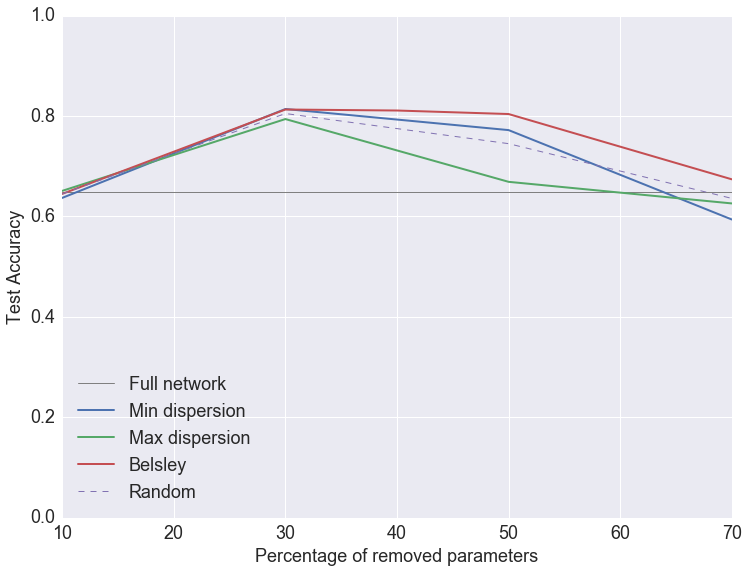

In [102]:
x=range(10,71,20)
f, ax = plt.subplots(figsize=(12, 9))
ax.plot(x, [0.649]*4, linewidth=1, color='grey', label='Full network')
ax.plot(x, [0.637,0.814,0.772,0.594], linewidth=2, label='Min dispersion')
ax.plot(x, [0.651, 0.794, 0.669,0.626], linewidth=2, label='Max dispersion')
ax.plot([10,30,40,50,70], [0.645,0.813,0.811,0.804,0.674], linewidth=2, label='Belsley')
ax.plot(x, [0.645, 0.805,0.745, 0.636], '--', linewidth=1, label='Random')

ax.legend(loc='lower left', fontsize=18)
ax.set_xlabel('Percentage of removed parameters',fontsize=18)
ax.set_ylabel('Test Accuracy',fontsize=18)
plt.tick_params(axis='both',  labelsize=18)
plt.ylim([0.,1.])
plt.show()

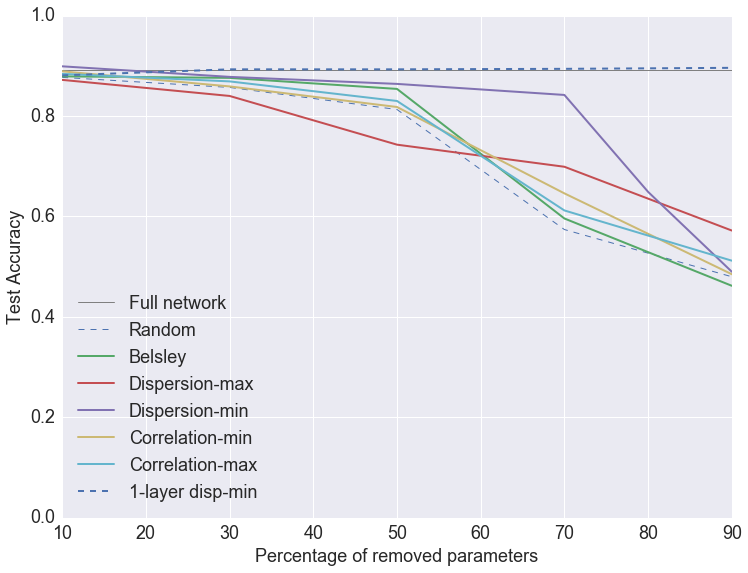

In [36]:
x=range(10,91,20)
f, ax = plt.subplots(figsize=(12, 9))
ax.plot(x, [0.891,0.891,0.891,0.891,0.891], linewidth=1, color='grey', label='Full network')
ax.plot(x, [0.877,0.857,0.813,0.574,0.480], '--', linewidth=1, label='Random')
ax.plot(x, [0.879,0.876,0.854,0.596,0.462], linewidth=2, label='Belsley')
ax.plot(x, [0.872,0.840,0.743,0.699,0.572], linewidth=2, label='Dispersion-max')
ax.plot([10,30,50,70,80,90], [0.899,0.878,0.864,0.842,0.649,0.490], linewidth=2, label='Dispersion-min')
ax.plot(x, [0.889,0.859,0.818,0.646,0.485], linewidth=2, label='Correlation-min')
ax.plot(x, [0.884,0.869,0.830,0.612,0.512], linewidth=2, label='Correlation-max')
ax.plot(x, [0.881,0.893,0.893,0.894,0.896], '--', linewidth=2, label='1-layer disp-min')

ax.legend(loc='lower left', fontsize=18)
ax.set_xlabel('Percentage of removed parameters',fontsize=18)
ax.set_ylabel('Test Accuracy',fontsize=18)
plt.tick_params(axis='both',  labelsize=18)
plt.ylim([0.,1.])
plt.show()

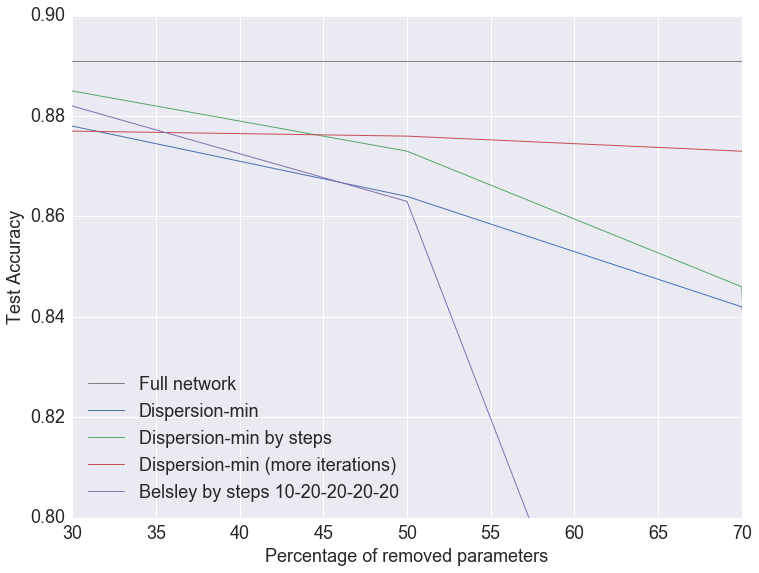

In [114]:
x=range(10,91,20)
f, ax = plt.subplots(figsize=(12, 9))
ax.plot([5, 10,30,50,70,80,90], [0.891,0.891,0.891,0.891,0.891,0.891,0.891], linewidth=1, color='grey', label='Full network')
ax.plot([5, 10,30,50,70,80,90], [0.888,0.899,0.878,0.864,0.842,0.649,0.490], linewidth=1, label='Dispersion-min')
ax.plot([10,30,50,70,80,90], [0.899,0.885,0.873,0.846,0.,0.], linewidth=1, label='Dispersion-min by steps')
ax.plot([5,10,30,50,70,80,90], [0.891,0.897,0.877,0.876,0.873,0.828,0.562], linewidth=1, label='Dispersion-min (more iterations)')
ax.plot([10,30,50,70], [0.879,0.882,0.863,0.690], linewidth=1, label='Belsley by steps 10-20-20-20-20')
# ax.plot(x, [0.879,0.876,0.854,0.596,0.462], linewidth=1, label='Belsley')

ax.legend(loc='lower left', fontsize=18)
ax.set_xlabel('Percentage of removed parameters',fontsize=18)
ax.set_ylabel('Test Accuracy',fontsize=18)
plt.tick_params(axis='both',  labelsize=18)
plt.ylim([0.8,0.9])
plt.xlim([30,70])
plt.show()